# CodeBERT + Logistic Regression for Vulnerability Detection

This script uses CodeBERT embeddings as semantic representations of code functions from the DiverseVul dataset, followed by a Logistic Regression classifier for binary vulnerability detection.

Steps:
1. Load and sample the DiverseVul dataset
2. Extract CodeBERT embeddings for each function
3. Train a Logistic Regression classifier
4. Evaluate performance with metrics and visualizations

In [ ]:
# Import Required Libraries
from transformers import RobertaTokenizer, RobertaModel
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
import json

# Loading the JSON file
file_path = "...diversevul_20230702.json"       # TODO: Update this path before running

# Load JSONL format line by line
data = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

# Inspect dataset quickly
df = pd.DataFrame(data)
df.head()

,func,target,cwe,project,commit_id,hash,size,message
0,int _gnutls_ciphertext2compressed(gnutls_sessi...,1,[],gnutls,7ad6162573ba79a4392c63b453ad0220ca6c5ace,73008646937836648589283922871188272089,157,added an extra check while checking the padding.
1,static char *make_filename_safe(const char *fi...,1,[CWE-264],php-src,055ecbc62878e86287d742c7246c21606cee8183,211824207069112513181516095447837228041,22,Improve check for :memory: pseudo-filename in ...
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...",1,[],busybox,251fc70e9722f931eec23a34030d05ba5f747b0e,21401706257394042943815500829552774160,232,uncompress: fix buffer underrun by corrupted i...
3,"static void cirrus_do_copy(CirrusVGAState *s, ...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,135590882627853658533498335902319684573,66,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,27696392987383562433164405181263025184,18,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."


In [ ]:
# Due to GPU contstraints of my PC, running the model on 100k samples. Feel free to adjust the samples based on GPU power available.
# Sample balanced dataset (85K safe, 15K vulnerable)

safe_df = df[df['target'] == 0].sample(85000, random_state=42)
vuln_df = df[df['target'] == 1].sample(15000, random_state=42)
df_100k = pd.concat([safe_df, vuln_df]).sample(frac=1, random_state=42)

In [ ]:
# Load CodeBERT (Microsoft's pretrained model)
# Microsoft's CodeBERT (trained on NL-PL pairs) is used for feature extraction

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.eval()  # inference mode only

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
# Move model to GPU if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
# Using a 20K sample for faster processing (adjust if hardware allows)
sample_df = df_100k.sample(20000, random_state=42)
texts = sample_df["func"].tolist()
labels = sample_df["target"].tolist()

In [ ]:
# Generate CodeBERT Embeddings
# Extract [CLS] token embedding (representing the whole function)

embeddings = []

with torch.no_grad():
    for code in tqdm(texts):
        inputs = tokenizer(code, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # Move to CPU
        embeddings.append(cls_embedding)

X = np.array(embeddings)
y = np.array(labels)

100%|██████████| 20000/20000 [04:37<00:00, 72.08it/s]


In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Logistic Regression Classifier
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.68      0.78      3400
           1       0.27      0.67      0.38       600

    accuracy                           0.68      4000
   macro avg       0.59      0.67      0.58      4000
weighted avg       0.82      0.68      0.72      4000



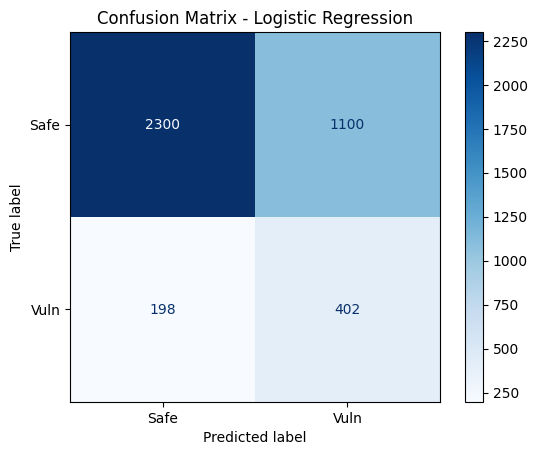

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=["Safe", "Vuln"], cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


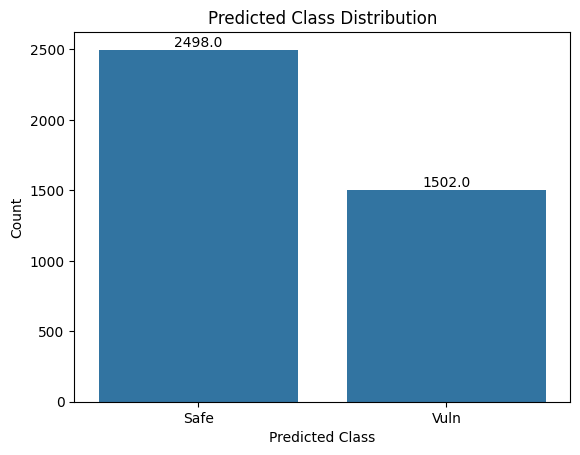

In [ ]:
# Plotting graphs for CodeBERT LR
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ax=sns.countplot(x=y_pred)
plt.title("Predicted Class Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Safe", "Vuln"])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()

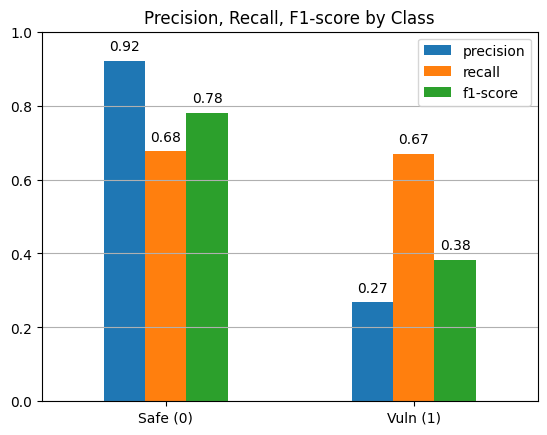

In [ ]:
# Plotting graphs for CodeBERT LR
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate report and extract class 0 and 1
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
metrics = df_report.loc[["0", "1"], ["precision", "recall", "f1-score"]]

# Plot
ax = metrics.plot(kind='bar')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks([0, 1], ["Safe (0)", "Vuln (1)"], rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add values on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.02),
                ha='center', va='bottom')

plt.show()
